# CoE 197 Final Project
### Edward Vincent M. Duero
### 2015-11198

## Import required libraries

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math
 
from skimage.color import rgb2gray
from skimage.transform import resize, rescale

Code for mounting Google Drive. Google Colab was used for this project.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load STL-10 Dataset

In [3]:
ds, info = tfds.load('stl10', 
                     split='unlabelled', 
                     shuffle_files=True, 
                     data_dir="/content/drive/MyDrive/datasets/stl10", 
                     with_info=True)

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='stl10',
    version=1.0.0,
    description='The STL-10 dataset is an image recognition dataset for developing unsupervised
feature learning, deep learning, self-taught learning algorithms. It is inspired
by the CIFAR-10 dataset but with some modifications. In particular, each class
has fewer labeled training examples than in CIFAR-10, but a very large set of 
unlabeled examples is provided to learn image models prior to supervised
training. The primary challenge is to make use of the unlabeled data (which
comes from a similar but different distribution from the labeled data) to build
a useful prior. All images were acquired from labeled examples on ImageNet.',
    homepage='http://ai.stanford.edu/~acoates/stl10/',
    features=FeaturesDict({
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=113000,
    splits={
        'test': 8000,
        'tr

Showing the original dataset

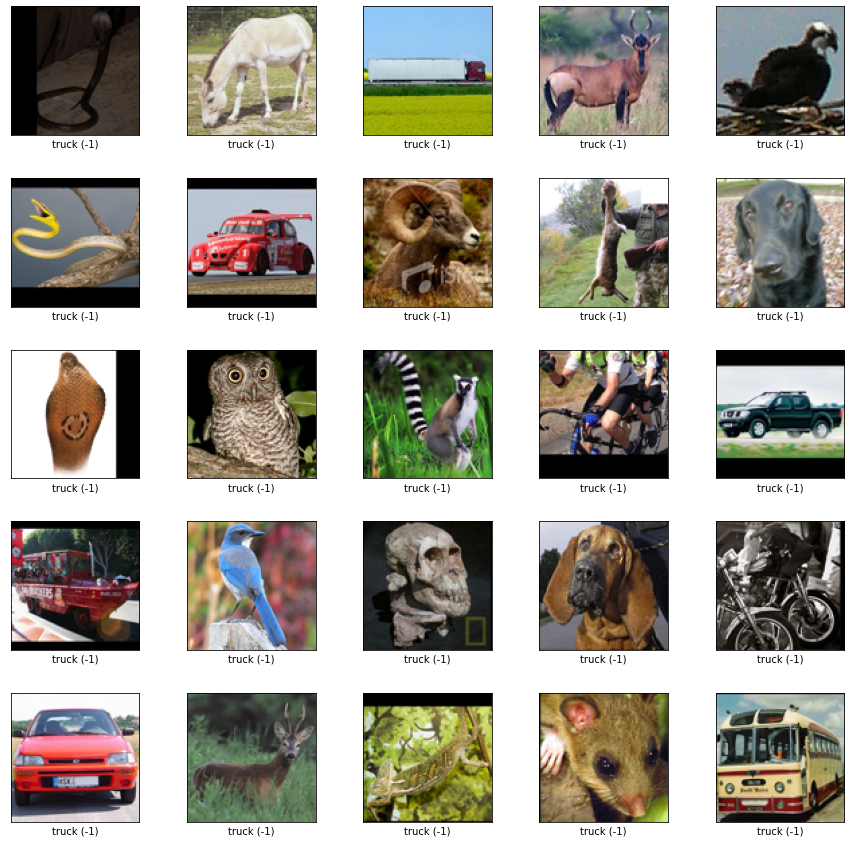

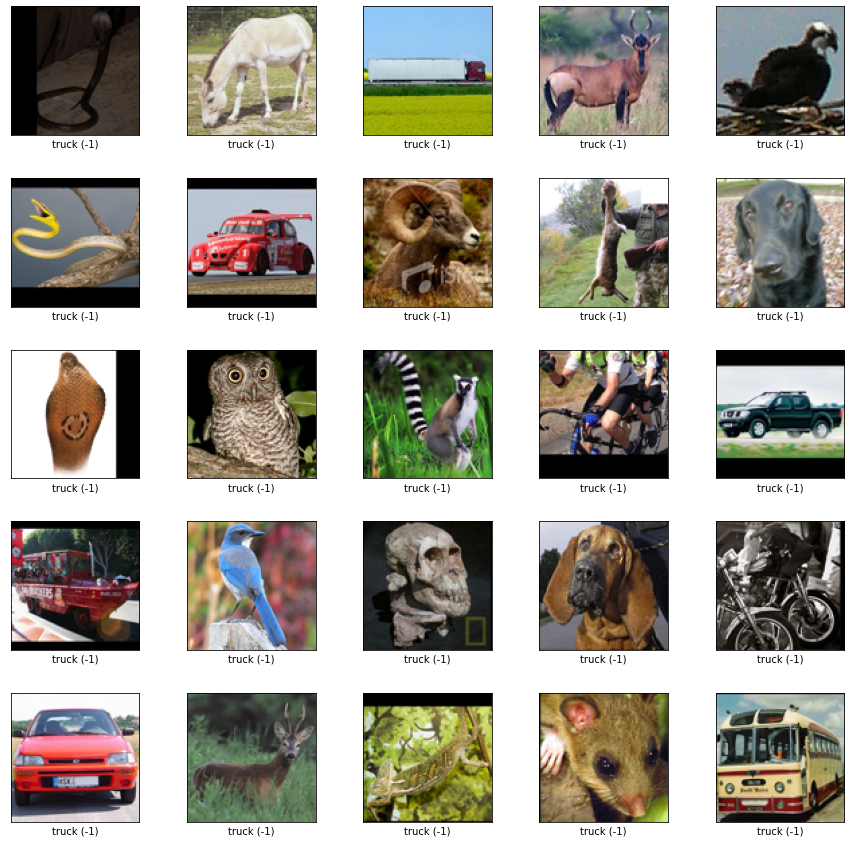

In [5]:
tfds.show_examples(ds, info, rows=5, cols=5)

## Define function for plotting images
We define a function for plotting the images for checking purposes.

In [6]:
def plot_images(images, title, n_images=25):
    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=20)
    side = int(math.sqrt(n_images))
    
    for i in range(n_images):
        plt.subplot(side, side, i+1)
        image = images[i]
        plt.imshow(image)
        plt.axis('off')
    
    plt.show()
    plt.close('all')

## Pre-process Loaded Dataset

A function for pre-processing the dataset was created. This function converts the dataset into gray scale by using `rb2gray` function from the `skimage` library, resize to a lower size using `resize` from the `skimage`, converts to `np.float32`, converts the dataset into numpy array, and normalizes it.



In [7]:
def pre_process(tfds_dataset):
  images = []
  
  print("Parsing dataset...", end='')
  for item in tfds_dataset:
    images.append(item['image'].numpy())
  print("Done!")

  print("Applying gray scale...", end='')
  # grayscale image
  images = list(map(rgb2gray, images))
  print("Done!")
  print("Converting to float...", end='')

  # convert to np.float32
  images = list(map(np.float32, images))
  print("Done!")
  print("Resizing... ", end='')

  # resize to lower dimensions
  images = list(map(lambda img: rescale(img, scale=0.4375),
                    images))
  print("Done!")
  print("Converting to numpy array...", end='')

  # convert to numpy array
  images = np.array(images)
  print("Done!")
  print("Normalize data...", end='')

  # normalize
  images = images/255.0
  print("Done!")

  return images

Now, let's use the function to pre-process the dataset

In [8]:
images = pre_process(ds)

Parsing dataset...Done!
Applying gray scale...Done!
Converting to float...Done!
Resizing... Done!
Converting to numpy array...Done!
Normalize data...Done!


After pre-processing, the dataset now looks as follows:

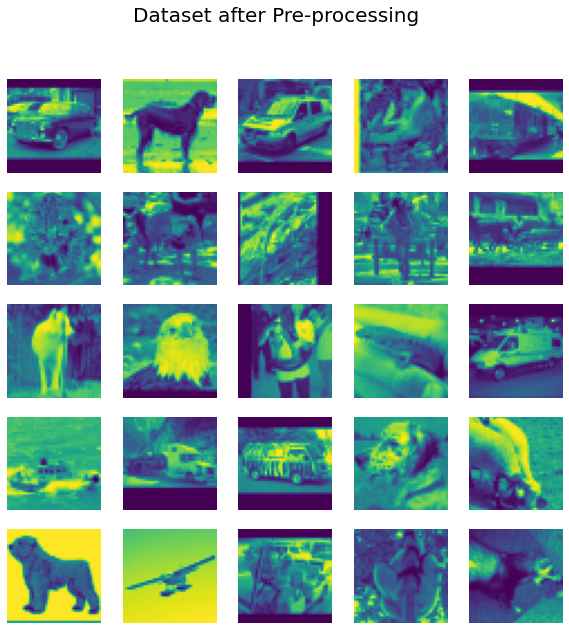

In [9]:
plot_images(images, "Dataset after Pre-processing")

The dataset now has the following parameters

In [10]:
print(images.shape)
print(images.dtype)

(100000, 42, 42)
float32


# Part 1: Low-dimensionality Reduction using PCA
Now that the pre-processing of the dataset is done, let's proceed with the experiments

## Define PCA for dimension reduction
A function for dimensionality reduction using PCA was first made.

In [11]:
def pca_dimension_reduction(dataset, orig_shape, n_components):
    # Step 1: Standardize the dataset by subtracting the mean 
    # and dividing it by the standard deviation
    Z = (dataset - np.mean(dataset))/np.std(dataset)
    
    # Step 2: Find the covariance matrix
    X = np.reshape(Z, (-1, len(Z)))
    S = np.matmul(X, np.transpose(X))/len(Z)
    
    D, B = np.linalg.eig(S)
    
    # Step 3: Projection or Low-rank approximation
    BM = B[:, :n_components]
    BM_BMT = np.matmul(BM, np.transpose(BM))
    R = np.matmul(BM_BMT, X)
    R = np.reshape(R, orig_shape)
    
    # Step 4: Backprojection
    R *= np.std(dataset)
    R += np.mean(dataset)
    R = np.clip(R, 0, 255)
    
    return R

## Define function for Mean Squared Error (MSE)
A measurement function for calculating the Mean Squared Error (MSE) is also defined

In [12]:
def mse(x, y):
    return np.square(np.subtract(x, y)).mean()

## Calculate the optimal z-dimension
The PCA dimensionality reduction function was used with varying dimensions to identify the optimal z-dimension. The plot of the MSE of the reduced dataset with original dataset is then plotted to easily identify this dimension

In [13]:
dimensions = [32, 64, 256, 512, 1028, 1200, 1400, 1600, 1700]
mse_list = []
i=0

for dim in dimensions:
  print("Dimension: ", dim)
  R = pca_dimension_reduction(images, images.shape, dim)
  mse_list.append(mse(images, R))
  print('Error: ', mse_list[i])
  i+=1


Dimension:  32
Error:  8.013705074317196e-07
Dimension:  64
Error:  7.05925296042979e-07
Dimension:  256
Error:  4.286843983848027e-07
Dimension:  512
Error:  2.673937472896707e-07
Dimension:  1028
Error:  1.1773073422544019e-07
Dimension:  1200
Error:  8.650422830747134e-08
Dimension:  1400
Error:  5.421031797892279e-08
Dimension:  1600
Error:  2.378364808014269e-08
Dimension:  1700
Error:  9.214798625976165e-09


Plot of the MSE for different PCA dimensions

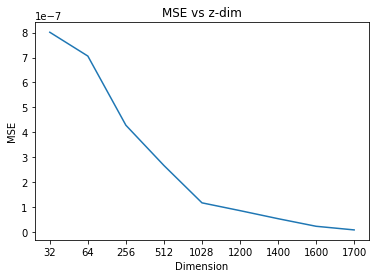

In [14]:
plt.plot(mse_list)
plt.ylabel("MSE")
plt.xlabel("Dimension")
plt.title("MSE vs z-dim")
plt.xticks(ticks=np.arange(0, len(dimensions)), labels=dimensions)
plt.show()

# Part 1 Conclusion
From the MSE vs z-dim plot, we can see that the mean squared error started to decrease linearly at z = 1028. At that point, the mean squared error does not seem to change greatly. Thus, we can conclude that **1028** is the optimum z-dimension.

# Part 2: Using the "optimal" z-dim PCA 
Let's create first the dataset with the obtained optimal z-dim PCA

In [15]:
pca_img = pca_dimension_reduction(images, images.shape, 1028)

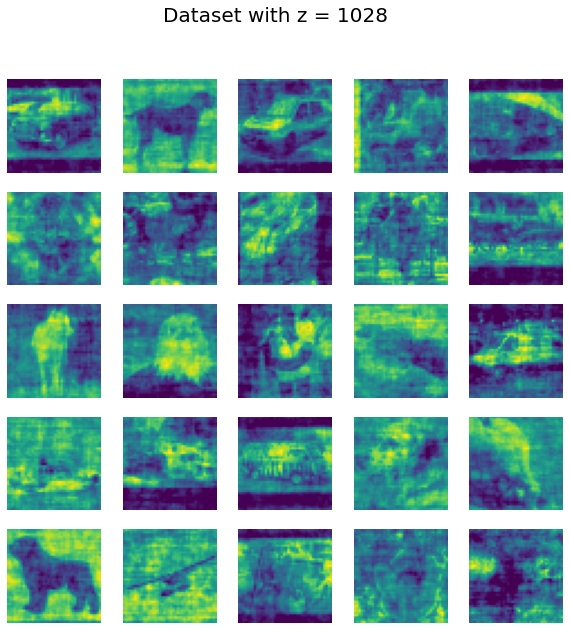

In [16]:
plot_images(pca_img, "Dataset with z = 1028")

## Define a Gaussian Mixture Model Function

For this part, I tried to implement the Gaussian Mixture Model from scratch as shown below. The implemented GMM works with with the data provided in the GMM example from class. However, it seems that the implementation does not work with the given dataset and the other image files as well. The system crashes, i.e., it ran out of RAM. As such, I used the Gaussian Mixture Model from sklearn instead to be able to produce results

In [17]:
from scipy.stats import multivariate_normal as mvn

def gmm(X_data, n_components, max_iteration):
    n_data, n_dim = X_data.shape
    
    # Initialize parameters
    # Mean
    mu = np.random.random((n_components, n_dim))

    # Covariance
    sigma = np.array([np.identity(n_dim)] * n_components)

    # Weights/Pi
    pi = np.random.random(n_components)
    pi /= pi.sum()

    # Responsibility
    r = np.full((n_components, n_data), fill_value=0.25)

    # Perform algorithm
    for iter in range(max_iteration):
        # E-step
        # Calculate the responsbility
        for i in range(n_components):
            r[i, :] = pi[i] * mvn(mu[i], sigma[i]).pdf(X_data)
        r /= r.sum(0)

        # M-step
        # Update the weights/pi
        pi = r.sum(1)
        pi /= n_data

        # Update the mean
        mu = np.dot(r, X_data)
        mu /= r.sum(1)[:, None]

        # Update the covariance
        sigma = np.zeros((n_components, n_dim, n_dim))
        for i in range(n_components):
            for j in range(n_data):
                x_mu = np.reshape(X_data[j] - mu[i], (n_dim,1))
                sigma[i] += r[i, j] * np.dot(x_mu, x_mu.T)
            sigma[i] /= r[i,:].sum()

    return pi, mu, sigma

In [ ]:
img_reshaped = np.reshape(pca_img, (pca_img.shape[0], -1))
res_pi, res_mu, res_sigma = gmm(img_reshaped, 10, 100)

## Data pre-processing
The dataset should only have a size of (n, m).  Convert it first by using `np.reshape`.

In [19]:
img_reshaped = np.reshape(pca_img, (pca_img.shape[0], -1))

In [20]:
img_reshaped.shape

(100000, 1764)

### Can we fit a 10-component GMM on the unlabeled dataset z code vectors from PCA?
To answer this, let's fit the dataset to a Gaussian Mixture Model with 10 components:

In [21]:
from sklearn.mixture import GaussianMixture as GM

gmm_model = GM(n_components=10, covariance_type='diag')
gmm_model.fit(img_reshaped)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Since the Gaussian Mixture model converged, then the answer is yes, we can fit a 10-component GMM on the unlabeled dataset z code vectors from PCA

### Can we use the GMM and labeled train set to assign labels to the 10 clusters in GMM?

Let's load first the labeled train set and pre-process it. But now, we'll need the labels to check the prediction accuracy of the GMM model. These are all done by the function `pre_process2` below:

In [30]:
def pre_process2(tfds_dataset):
  images = []
  labels =[]
  
  print("Parsing dataset...", end='')
  for item in tfds_dataset:
    images.append(item['image'].numpy())
    labels.append(item['label'].numpy())
  print("Done!")

  print("Applying gray scale...", end='')
  # grayscale image
  images = list(map(rgb2gray, images))
  print("Done!")
  print("Converting to float...", end='')

  # convert to np.float32
  images = list(map(np.float32, images))
  print("Done!")
  print("Resizing... ", end='')

  # resize to lower dimensions
  images = list(map(lambda img: rescale(img, scale=0.4375),
                    images))
  print("Done!")
  print("Converting to numpy array...", end='')

  # convert to numpy array
  images = np.array(images)
  print("Done!")
  print("Normalize data...", end='')

  # normalize
  images = images/255.0
  print("Done!")

  
  return images, labels

Loading the dataset and pre-processing it

In [31]:
train_set = tfds.load('stl10', 
                      split='train', 
                      shuffle_files=True, 
                      data_dir="/content/drive/MyDrive/datasets/stl10")

train_images, train_labels = pre_process2(train_set)

Parsing dataset...Done!
Applying gray scale...Done!
Converting to float...Done!
Resizing... Done!
Converting to numpy array...Done!
Normalize data...Done!


Next, we'll use the fitted GMM model above (`gmm_model`) to predict the labels of the train dataset. Using the `predict` method of the Gaussian Mixture Model, we can predict the labels for each dataset.

In [32]:
train = np.reshape(train_images, (train_images.shape[0], -1))

predictions = gmm_model.predict(train)

Since the function runs without error, then, the answer is yes, we can use the GMM and labeled train set to assign labels to the 10 clusters in GMM. Checking the result:

In [43]:
gmm_cluster = []

for i in range(10):
  pred_results = [idx for idx in predictions if predictions[idx] == i]
  gmm_cluster.append([train_labels[idx] for idx in pred_results])
  print(gmm_cluster[i])

[]
[]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

We can see from above that the Gaussian Mixture Model seem to be able to cluster the labels 2, 4, and 9. Label 8 seems to have been clustered into two. The rest are clustered together or was not clustered. The accuracy was measured by dividing the number of correctly labeled images by the total number of images

In [57]:
correct = 0

for i in range(10):
  for items in gmm_cluster[i]:
    if items == i:
      correct += 1

print("Accuracy (correct/total): ", 
      float(correct/len(predictions))*100, 
      "%")

Accuracy (correct/total):  13.3 %


Thus, we can see that the accuracy of the Gaussian Mixture Model is very low with only 13.3%. Perhaps this is due to the resizing and lowering the dimensions of the dataset which could have reduced the necessary features for proper clustering. 

### Can we build an STL generative model using unlabeled dataset PCA z code vectors and GMM?
To do this, we could use the `sample` method of the GMM model. This function generates a sample using the obtained mean and covariance of a specific cluster or component. Let's generate 6 samples and qualitatively check the result

In [49]:
sampled_image, sampled_labels = gmm_model.sample(25)
sampled_image = np.reshape(sampled_image, 
                           (sampled_image.shape[0], 42, 42))

sampled_image.shape

(25, 42, 42)

Plotting the obtained sample:

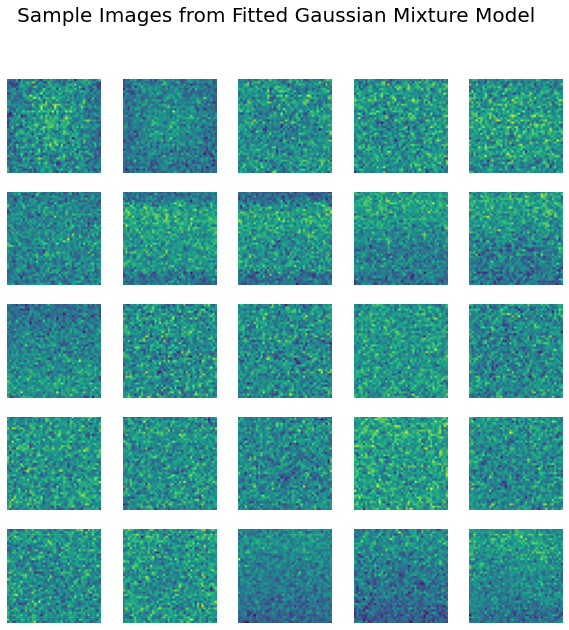

In [50]:
plot_images(sampled_image, 
            "Sample Images from Fitted Gaussian Mixture Model")

Using the `sample` method of the Gaussian Mixture Model, we can indeed build an STL generative model. However, the resulting samples are not good. We can only see blurs. Perhaps resizing and converting the images to a lower dimension have caused the model to produce such results. Also, the Gaussian Mixture Model might not be the best tool for generating samples.